<a href="https://colab.research.google.com/github/Riyajia/Machine_Learning/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<h2 align="left">Stock Trend Prediction and closing Price prediction using XGBoost and LSTM</h2>
<h5 align="left">Subject: CP640 Machine Learning
<h5 align="left">Project by: Riya Biswas</h5>
<h5 align= "left">Dataset from : <a href = "https://bit.ly/3fgW8uL"</a> Kaggle.com </h5>


---

##Importing libraries

Importing some of the required libraries
1. pandas library for data manupulation and analysis
2. matplotlib for ploting graphs and visualization 
3. math library for mathematical computation
4. importing warning library to supress warnings. 
5. XGBoost libraries and evaluation metrics library from Scikit learn
6. Libraries for LSTM models and evaluations from Keras


In [1]:
#import libraries
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import matplotlib.pyplot as plt
import math
import io

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#For XGBoost model creation and evaluation
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix

#For LSTM model creation and evaluation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, LeakyReLU
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.metrics import mean_squared_error,  mean_absolute_error



## Data Exploration and Data Cleaning

Loading the dataset, the dataset was uploaded to Github first for easier loading of the data to Google Colab



In [2]:
url = "https://raw.githubusercontent.com/Riyajia/Machine_Learning-/main/indexData.csv"
df = pd.read_csv(url)

In [3]:
#Checking the datatypes and number of rows with valid data for each columns

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Date       112457 non-null  object 
 2   Open       110253 non-null  float64
 3   High       110253 non-null  float64
 4   Low        110253 non-null  float64
 5   Close      110253 non-null  float64
 6   Adj Close  110253 non-null  float64
 7   Volume     110253 non-null  float64
dtypes: float64(6), object(2)
memory usage: 6.9+ MB


<font size = 3>Checking the first 5 rows of the dataset </font>

In [5]:
# The Head function shows thw first 5 rows of the dataset by default
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


<font size = 3>Checking the last 5 rows of the dataset </font>

In [6]:
# The Tail function shows the last 5 rows of the dataset by default. 
df.tail()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0
112456,N100,2021-06-02,1258.489990,1263.709961,1258.239990,1263.619995,1263.619995,148465000.0


As the 'Date' coloumn in the dataset is an Object type, it is first converted to Date-Time type and then setting it as the  for the dataset. After that the original Date column is dropped.

In [4]:
# Changing the date type from object to Date Time type and setting the Date column as index
df.index = pd.to_datetime(df['Date'])
 
# dropping The original date column
df = df.drop(['Date'], axis='columns')

#Checking the change took effect
df.head()

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


### Data Grouping

Checking for the Unique values in the Index column (i.e. the different exchanges) that are present in the dataset. 

NOTE: The Index column is not be mixed with the index of the dataset, it is just the column name that was given to the exchanges in the dataset. 

In [8]:
#Checking what Exchanges are present in the dataset. 
df['Index'].unique()


array(['NYA', 'IXIC', 'HSI', '000001.SS', 'GSPTSE', '399001.SZ', 'NSEI',
       'GDAXI', 'KS11', 'SSMI', 'TWII', 'J203.JO', 'N225', 'N100'],
      dtype=object)

Out of the 14 exchanges present in the dataset, only 3 exchanges are being considered.
Grouping the Stock Exchanges together and only selecting the ones required for this project
1. New York Stock Exchange- NYA 
2. NASDAQ - IXIC
3. Toronto Stock Exchange - GSPTSE


In [5]:
exchange = df.groupby(df.Index)

#NY stock market data
NYA = exchange.get_group("NYA")  

#NASDQ data
IXIC = exchange.get_group("IXIC") 

#Toronto Stock Market data
GSPTSE = exchange.get_group("GSPTSE")       

### Checking for NAN values

In the next few cells it is being checked whether there are any NAN values in the 3 sub-dataset and droping if there is only a few nan values.

#### NYA dataset 

In [6]:
#Checking if there is any nan values in the NYA 

NYA.isna().any()

Index        False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
dtype: bool

In [11]:
#Checking how many rows in each column has nan values

NYA.isna().sum()

Index        0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [12]:
#Checking if it is only 1 row of missing data or separate rows have 1 missing values each

NYA[NYA.isna().any(axis=1)]

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1967-02-23,NYA,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# As it is only 1 row with missing data that too before 1990, dropping the row with nan values

NYA.dropna(inplace=True)

In [9]:
#Checking that dropping was done correctly. 

NYA.isnull().sum()

Index        0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### IXIC dataset

In [15]:
#Checking if there are any nan values

IXIC.isna().any()

Index        False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

As there are no nan values in the IXIC dataset so nothing further is done


#### GSPTSE dataset

In [10]:
#Checking if there are any nan values

GSPTSE.isna().any()

Index        False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
dtype: bool

In [17]:
#Checking how many rows in each column has nan values

GSPTSE.isna().sum()

Index          0
Open         250
High         250
Low          250
Close        250
Adj Close    250
Volume       250
dtype: int64

In [18]:
#checking if 250 rows or more has missing data 

GSPTSE[GSPTSE.isna().any(axis=1)]

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1979-07-02,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
1979-08-06,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
1979-09-03,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
1979-10-08,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
1979-11-22,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2004-08-02,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-06,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-11,GSPTSE,NaN,NaN,NaN,NaN,NaN,NaN


As there are 250 rows with missing data, interpolation is done to fill the dataset instead of droping the nan rows.  

In [11]:
#Filling the nan values by interpolation

GSPTSE = GSPTSE.interpolate()
GSPTSE.head(10)

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1979-06-29,GSPTSE,1614.699951,1619.800049,1614.699951,1618.400024,1614.290039,0.0
1979-07-02,GSPTSE,1614.149964,1616.700012,1608.199951,1610.600036,1606.509949,0.0
1979-07-03,GSPTSE,1613.599976,1613.599976,1601.699951,1602.800049,1598.729858,0.0
1979-07-04,GSPTSE,1601.500000,1601.500000,1589.500000,1591.400024,1587.358765,0.0
1979-07-05,GSPTSE,1590.000000,1590.000000,1582.500000,1583.900024,1579.877686,0.0
1979-07-06,GSPTSE,1583.900024,1586.599976,1578.300049,1586.599976,1582.570923,0.0
1979-07-09,GSPTSE,1586.599976,1588.500000,1585.500000,1586.300049,1582.271606,0.0
1979-07-10,GSPTSE,1584.900024,1584.900024,1579.000000,1580.199951,1576.187012,0.0
1979-07-11,GSPTSE,1576.800049,1576.800049,1560.900024,1563.199951,1559.230347,0.0


In [12]:
#rechecking if there are any nan rows remaning

GSPTSE.isna().any()

Index        False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

### Rolling average for all 3 dataset

<font size = 3> Calculating a rolling average for 100 days of the closing price column for all the three indices </font>

In [21]:
NYA['roll_avg_100'] = NYA['Close'].rolling(window = 100).mean()
IXIC['roll_avg_100']= IXIC['Close'].rolling(window = 100).mean()
GSPTSE['roll_avg_100'] = GSPTSE['Close'].rolling(window =100).mean()

<font size = 3> Calculating a rolling average for 200 days of the closing price column for all the three indices </font>

In [22]:
NYA['roll_avg_200'] = NYA['Close'].rolling(window = 200).mean()
IXIC['roll_avg_200']= IXIC['Close'].rolling(window = 200).mean()
GSPTSE['roll_avg_200'] = GSPTSE['Close'].rolling(window = 200).mean()

### Removing historic data (data before 1990)

In [13]:
NYA = NYA.loc["1990-01-01":].copy()
IXIC = IXIC.loc["1990-01-01":].copy()
GSPTSE = GSPTSE.loc["1990-01-01":].copy()

### Raw Data Visualization and rolling avg visualization

Ploting Closing price of New York, NASDAQ and Toronto Stock exchange with respect to date. This shows us that the market has risen quite high over the past few decades. 

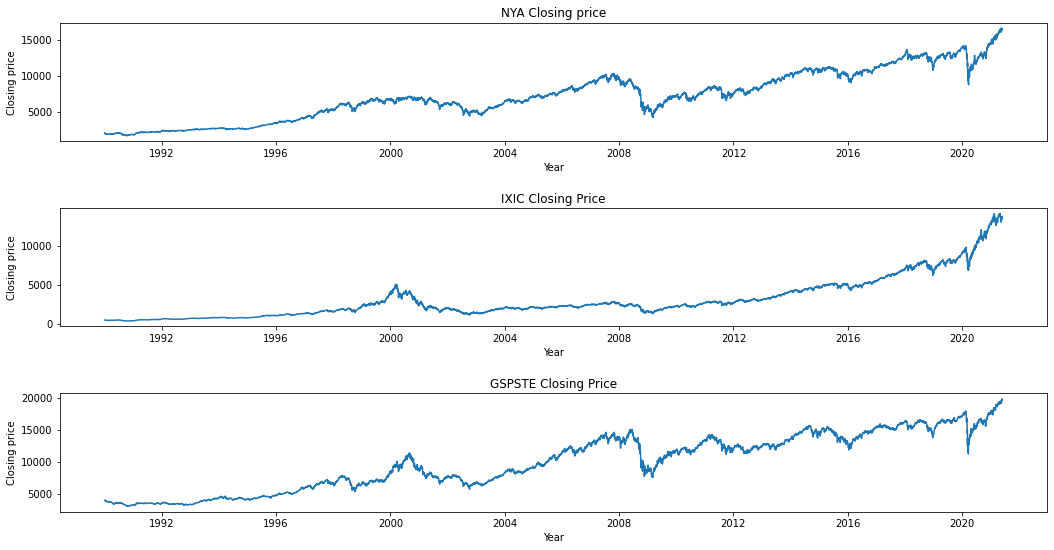

In [24]:
#Stacking the 3 plots in one sections for easier comparison. 

plt.figure(figsize = (15,8))
plt.subplot(3,1,1)    
plt.plot(NYA['Close'])          
plt.title('NYA Closing price')
plt.xlabel("Year")
plt.ylabel("Closing price")

plt.subplot(3,1,2)       
plt.plot(IXIC['Close'])        
plt.title('IXIC Closing Price')
plt.xlabel("Year")
plt.ylabel("Closing price")

plt.subplot(3,1,3)      
plt.plot(GSPTSE['Close'])  
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.title('GSPSTE Closing Price')
plt.tight_layout(pad=2.0)



From the plot above we can see that New York stock exchange and Toronto Stock Exchange follow each other very closely. i.e. Both the markets falls and rises almost similarly. 

Ploting the rolling average prices over the closing price. Logic is if the 100 days rolling average crosses over the 200 days rolling average then the market has an upward trend and vice-versa.

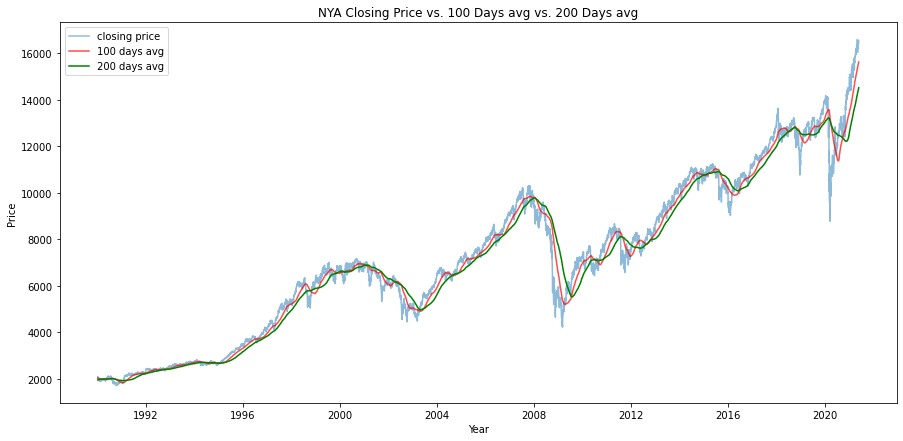

In [25]:
#NYA plot

plt.figure(figsize=(15,7))
plt.plot(NYA['Close'], label = 'closing price', alpha = 0.5)
plt.plot(NYA['roll_avg_100'], color = 'r', label = '100 days avg', alpha = 0.7)
plt.plot(NYA['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('NYA Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

Plotting a zoomed in section of the above graph to show the 100 days and 200 days crossovers

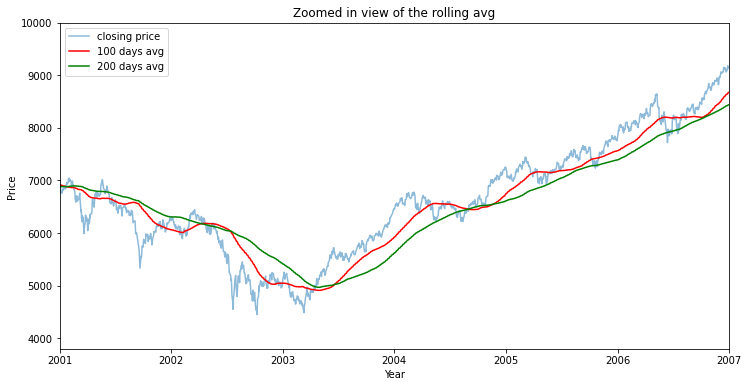

In [26]:
#NYA plot
import datetime

plt.figure(figsize=(12,6))
plt.plot(NYA['Close'], label = 'closing price', alpha = 0.5)
plt.plot(NYA['roll_avg_100'], color = 'r', label = '100 days avg')
plt.plot(NYA['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.xlim([datetime.date(2001,1,1),datetime.date(2007,1,1)])
plt.ylim(3800,10000)
plt.legend()
plt.title('Zoomed in view of the rolling avg')
plt.show()

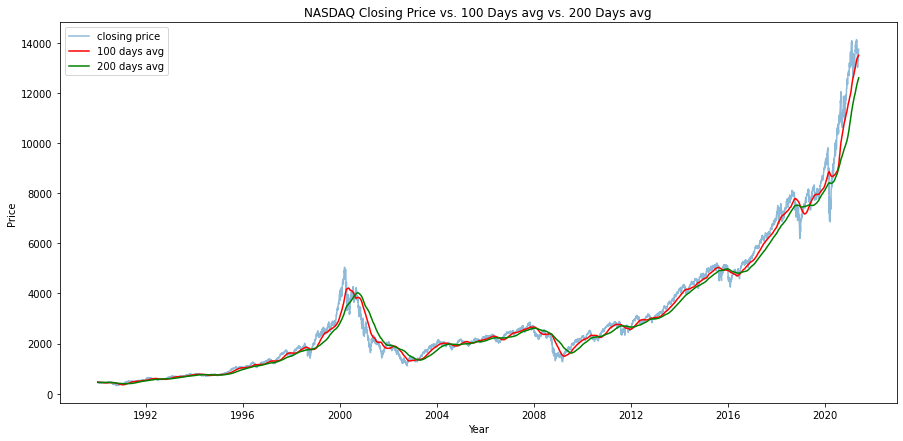

In [27]:
#NASDAQ Plot
plt.figure(figsize=(15,7))
plt.plot(IXIC['Close'], label = 'closing price', alpha = 0.5)
plt.plot(IXIC['roll_avg_100'], color = 'red', label = '100 days avg')
plt.plot(IXIC['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('NASDAQ Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

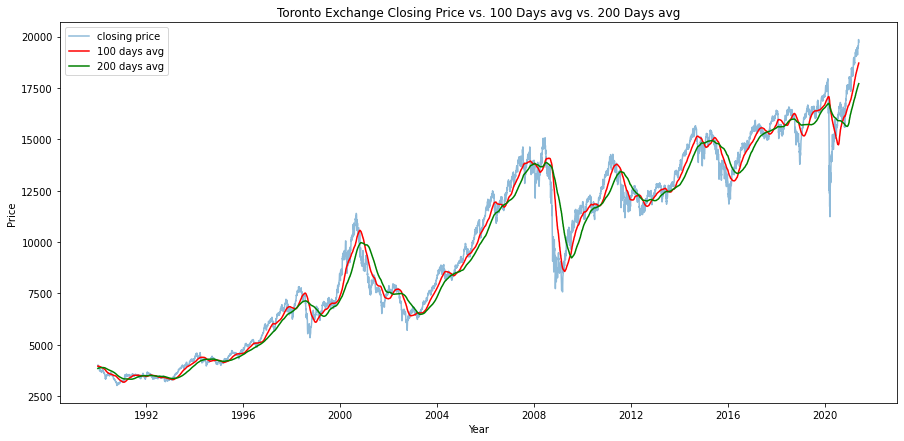

In [28]:
#Toronto Stock Market Plot
plt.figure(figsize=(15,7))
plt.plot(GSPTSE['Close'], label = 'closing price', alpha = 0.5)
plt.plot(GSPTSE['roll_avg_100'], color = 'red', label = '100 days avg')
plt.plot(GSPTSE['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('Toronto Exchange Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

## XGBOOST

For the 1st part of the project. i.e. the classification part, XGBoost alogorithm is being used. 

Creating a **"Tomorrow"** column by shifting the data by 1 day from the close column and a **"Target"** column which has either 0 or 1 depending whether the value of tomorrow column is higher or lower than the close column on a particular day. These values will be used to predict the trend of the market.

In [14]:
#creating the tomorrow and target column for NYA

NYA["Tomorrow"] = NYA["Close"].shift(-1)
NYA["Target"] = (NYA["Tomorrow"] > NYA["Close"]).astype(int)


In [15]:
#creating the tomorrow and target column for IXIC

IXIC["Tomorrow"] = IXIC["Close"].shift(-1)
IXIC["Target"]= (IXIC["Tomorrow"] > IXIC["Close"]).astype(int)


In [16]:
#creating the tomorrow and target column for GSPTSE

GSPTSE["Tomorrow"] = GSPTSE["Close"].shift(-1)
GSPTSE["Target"]= (GSPTSE["Tomorrow"] > GSPTSE["Close"]).astype(int)


### XGBoost for New York Stock Exchange

Before training our Initial model for the **New York Stock Exchange** using XGBoost the following steps will be done as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.
 

In [17]:
#Removing the columns that wont be required for our prediction
NYA  = NYA.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 85% for training and 15% testing
train_length = math.ceil(len(NYA) * .85) 
train_NYA = pd.DataFrame(NYA.iloc[:train_length])

# taking 15% of data for testing
test_NYA =pd.DataFrame(NYA.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]


Defining the initial model uisng XGBoost

In [18]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [19]:
model.fit(train_NYA[predictors], train_NYA['Target'])
predictions = model.predict(test_NYA[predictors])

Calculating the precision score and the accuracy score for the model. 

In [20]:
print("Precision Score for our model is", round((precision_score(test_NYA["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_NYA["Target"],predictions)*100),2))

Precision Score for our model is 54.93
Accuracy Score for our model is 44.9


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later**

Hyperparameter tuning using Randomized Search 

In [81]:
#Selecting the parameters to tune
"""
from sklearn.model_selection import RandomizedSearchCV

params = {"learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
          "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
         # "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [800, 1000,1200,1500,2000,2500],  
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10],
          "max_feature" : ['auto', 'sqrt']
          }
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [95]:
#Creating the randomized search model. 
"""
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3)
"""

In [96]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_NYA[predictors],train_NYA['Target'])
"""

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'max_feature': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 3, 4, 5, 10],
                                        'n_estimators': [800, 1000, 1200, 1500,
                                                         2000, 2500]},
                   scoring='roc_auc

In [97]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

XGBClassifier(criterion='friedman_mse', gamma=0.2, learning_rate=0.2,
              loss='exponential', max_depth=10, max_feature='sqrt',
              min_samples_split=5, n_estimators=2500)

Redefining the model with the best estimators from the randomized search

In [22]:
model_tuned = xgb.XGBClassifier(loss='exponential', 
                          n_estimators = 1000,  
                          criterion ='squared_error', 
                          max_depth = 10,
                          min_samples_split = 3, 
                          gamma=0.1,
                          colsample_bytree=0.3,
                          max_feature = "auto", 
                          learning_rate=0.05
                          )

Fitting the tuned model with the training data again.

In [23]:
model_tuned.fit(train_NYA[predictors], train_NYA['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='squared_error', gamma=0.1,
              learning_rate=0.05, loss='exponential', max_depth=10,
              max_feature='auto', min_samples_split=3, n_estimators=1000)

Doing the predictions on the test data and converting the data into a pandas series. 

In [24]:
predictions1 = model_tuned.predict(test_NYA[predictors])
preds = pd.Series(predictions1, index=test_NYA.index, name="Predictions")

Potting the predictions into a confusion matrix

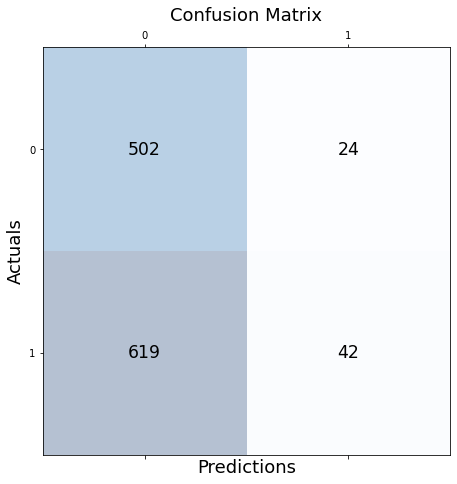

In [25]:
con_mat= confusion_matrix(test_NYA["Target"], preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Creating a combined table for the actual target class and the predicted target class for further understanding the predictions that were done. 

In [26]:
combined = pd.concat([test_NYA["Target"], preds], axis=1)
combined

,Target,Predictions
Date,,
2016-09-12,0,1
2016-09-13,0,0
2016-09-14,1,1
2016-09-15,0,0
2016-09-16,1,0
...,...,...
2021-05-24,0,0
2021-05-25,1,0
2021-05-26,1,0


Evaluating the model

In [27]:
#Calculating precision and accuracy scores

print("Precision Score for our model is", round((precision_score(test_NYA["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_NYA["Target"],preds)*100),2))

Precision Score for our model is 63.64
Accuracy Score for our model is 45.83


In [28]:
#Making a Classification report for our model

print(classification_report(test_NYA["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.45      0.95      0.61       526
           1       0.64      0.06      0.12       661

    accuracy                           0.46      1187
   macro avg       0.54      0.51      0.36      1187
weighted avg       0.55      0.46      0.33      1187



### XGBoost for NASDAQ

Like before doing the same steps for **NASDAQ** stock Exchange using XGBoost the following steps will be done as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.
4. Fitting the training data set to the model. 

In [48]:
#Removing the columns that wont be required for our prediction
IXIC  = IXIC.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 80% for training and 20% testing
train_length = math.ceil(len(IXIC) * .85) 
train_IXIC = pd.DataFrame(IXIC.iloc[:train_length])

# taking 15% of data for testing
test_IXIC =pd.DataFrame(IXIC.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]

Defining the initial model uisng XGBoost

In [49]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [50]:
model.fit(train_IXIC[predictors], train_IXIC['Target'])
predictions = model.predict(test_IXIC[predictors])

Calculating the precision score and the accuracy score for the model. 

In [51]:
print("Precision Score for our model is", round((precision_score(test_IXIC["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_IXIC["Target"],predictions)*100),2))

Precision Score for our model is 50.0
Accuracy Score for our model is 42.54


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later**

Hyperparameter tuning using Randomized Search 

In [ ]:
#List of Parameters to tune
"""
params = {"learning_rate" : [0.05,0.10,0.15,0.20],
          "max_depth" : [ 3, 4, 5, 6, 10],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [1000,1200,1500,2000,2500],  
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10]}
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [ ]:
#Creating the randomized search model.
"""
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=6,verbose=3)
"""

In [ ]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_IXIC[predictors],train_IXIC['Target'])
"""

In [ ]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

XGBClassifier(colsample_bytree=0.4, criterion='mse', gamma=0.0,
              learning_rate=0.15, loss='exponential', max_depth=5,
              min_child_weight=3, min_samples_split=5, n_estimators=2500)

Redefining the model with the best estimators from the randomized search

In [52]:
model_tuned = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 1,
                          min_samples_split = 10,
                          min_child_weight=5,
                          colsample_bytree=0.3, 
                          gamma=0.0, 
                          learning_rate=0.02,
                          )

Fitting the tuned model

In [53]:
model_tuned.fit(train_IXIC[predictors], train_IXIC['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='mse', gamma=0.0,
              learning_rate=0.02, loss='log_loss', max_depth=1,
              min_child_weight=5, min_samples_split=10, n_estimators=1000)

Doing the predictions

In [55]:
predictions1 = model_tuned.predict(test_IXIC[predictors])
preds = pd.Series(predictions1, index=test_IXIC.index,name="Predictions")

Creating the Confusion matrix and plotting the matrix

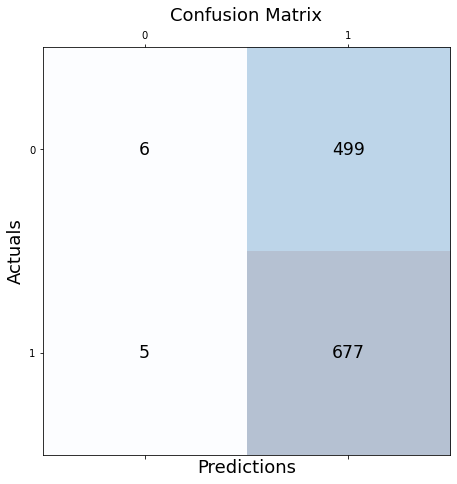

In [56]:
con_mat= confusion_matrix(test_IXIC["Target"], preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Combining the actual target and predicted target in a table.  

In [57]:
combined = pd.concat([test_IXIC["Target"], preds], axis=1)
combined

,Target,Predictions
Date,,
2016-09-12,0,0
2016-09-13,1,0
2016-09-14,1,0
2016-09-15,0,0
2016-09-16,0,1
...,...,...
2021-05-24,0,1
2021-05-25,1,1
2021-05-26,0,1


Calculating the Precision Score and Accuracy Score

In [58]:
print("Precision Score for our model is", round((precision_score(test_IXIC["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_IXIC["Target"],preds)*100),2))

Precision Score for our model is 57.57
Accuracy Score for our model is 57.54


In [59]:
#Making a Classification report for our model

print(classification_report(test_IXIC["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.55      0.01      0.02       505
           1       0.58      0.99      0.73       682

    accuracy                           0.58      1187
   macro avg       0.56      0.50      0.38      1187
weighted avg       0.56      0.58      0.43      1187



### XGBoost for Toronto Stock Exchange

Doing the same steps again for **Toronto Stock Exchange** XGBoost will be used for trend prediction as well and before that the following steps are taken as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.

In [60]:
#Removing the columns that wont be required for our prediction
GSPTSE  = GSPTSE.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 85% for training and 15% testing
train_length = math.ceil(len(GSPTSE) * .85) 
train_GSPTSE = pd.DataFrame(GSPTSE.iloc[:train_length])

# taking 15% of data for testing
test_GSPTSE =pd.DataFrame(GSPTSE.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]

Defining the initial model uisng XGBoost

In [61]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [62]:
model.fit(train_GSPTSE[predictors], train_GSPTSE['Target'])
predictions = model.predict(test_GSPTSE[predictors])

Calculating the precision score and the accuracy score for the model. 

In [63]:
print("Precision Score for our model is", round((precision_score(test_GSPTSE["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_GSPTSE["Target"],predictions)*100),2))

Precision Score for our model is 58.68
Accuracy Score for our model is 47.63


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later.**

Hyperparameter tuning using Randomized Search 

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
          "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [500, 800, 1000,1200,1500], 
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10]}
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [ ]:
"""
#Creating the randomized search model. 
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
"""

In [ ]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_GSPTSE[predictors],train_GSPTSE['Target'])
"""

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'min_samples_split': [2, 3, 4, 5, 10],
                                        'n_

In [ ]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

XGBClassifier(colsample_bytree=0.7, criterion='friedman_mse', gamma=0.1,
              learning_rate=0.15, loss='log_loss', max_depth=12,
              min_samples_split=2, n_estimators=1000)

Redefining the model with the best estimators from the randomized search

In [64]:
model_tuned = xgb.XGBClassifier(loss='exponential', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 8,
                          min_samples_split = 2,
                          min_child_weight=5,
                          colsample_bytree=0.3, 
                          gamma=0.0, 
                          learning_rate=0.02,
                          )

Fitting the tuned model

In [65]:
model_tuned.fit(train_GSPTSE[predictors], train_GSPTSE['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='mse', gamma=0.0,
              learning_rate=0.02, loss='exponential', max_depth=8,
              min_child_weight=5, min_samples_split=2, n_estimators=1000)

Predicting using the tuned model

In [66]:
predictions1 = model_tuned.predict(test_GSPTSE[predictors])
preds = pd.Series(predictions1, index=test_GSPTSE.index, name= "Predictions")

Creating and Plotting the confusion matrix

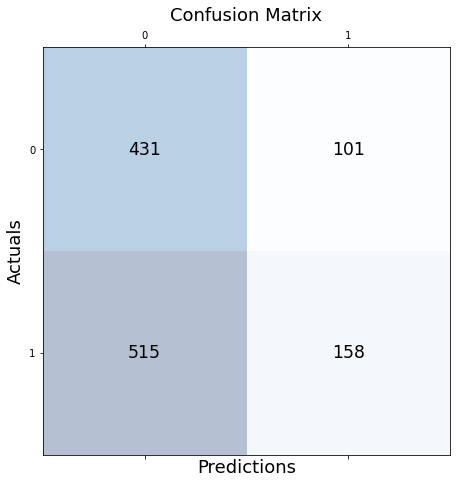

In [67]:
con_mat= confusion_matrix(test_GSPTSE["Target"], predictions1)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Converting the predictions into a Pandas series and then combining into a table with the Target Column. 

In [68]:
combined = pd.concat([test_GSPTSE["Target"], preds], axis=1)
combined

,Target,Predictions
Date,,
2016-08-11,0,1
2016-08-12,1,1
2016-08-15,0,1
2016-08-16,0,0
2016-08-17,0,1
...,...,...
2021-05-25,1,0
2021-05-26,1,0
2021-05-27,1,0


Calculating the Precision Score and Accuracy Score

In [69]:
#recalculating the precision score and accuracy score

print("Precision Score for our model is", round((precision_score(test_GSPTSE["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_GSPTSE["Target"],preds)*100),2))

Precision Score for our model is 61.0
Accuracy Score for our model is 48.88


In [70]:
#Making a Classification report for the model

print(classification_report(test_GSPTSE["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.46      0.81      0.58       532
           1       0.61      0.23      0.34       673

    accuracy                           0.49      1205
   macro avg       0.53      0.52      0.46      1205
weighted avg       0.54      0.49      0.45      1205



## Long Short-Term Memory(LSTM)

Using LSTM to predict prices of the 3 Stock exchnages. 

* Only keeping the close column for the price prediction using LSTM


In [29]:
#Selecting just the Close columns for our model
NYA = NYA[['Close']]
IXIC = IXIC[['Close']]
GSPTSE = GSPTSE[['Close']]


### LSTM for New York Stock Exchange

Predicting the NYA stock exchange in the following cells. Steps taken are as follows

*   Splitting the dataset into training and testing data sets
*   Scaling the data using Standard Scaler
*   Training dataset and testing dataset will both be divided into features and labels subset
*   Creating the LSTM model
*   Fitting data to the model
*   Ploting the training loss and actual vs. predicted prices
*   Calculating the mean squared error for both the training and test predictions. 

In [30]:
# taking 85% of the total data for training so the rest 15% will be for testing
train_length = math.ceil(len(NYA) * .85) 
NYA_train = NYA.iloc[:train_length]

# taking 15% of data for testing
NYA_test = NYA.iloc[train_length:]

print(NYA_train.shape)
print(NYA_test.shape)


(6727, 1)
(1187, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [31]:
#Data scaling
scaled_train_NYA = sc.fit_transform(NYA_train)
print(scaled_train_NYA.shape)


(6727, 1)


Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

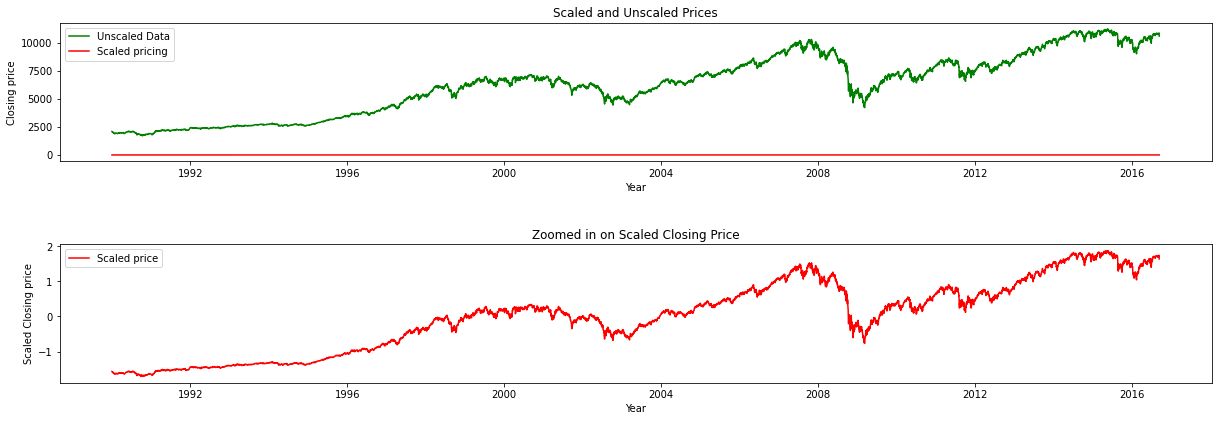

In [32]:
scaled_NYA_df = pd.DataFrame(scaled_train_NYA, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
#plt.plot(NYA_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(NYA_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(NYA_train.index, scaled_NYA_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(NYA_train.index,scaled_NYA_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Dividing the data in such way is called a Sliding Window split, where the labels will be the data of Day 61 till the end of the dataset and will depend on the data from the previous 60 days. 

The window will slide till the end of the dataset, where features will always be 60 days sliding over by 1 day and the 61st data will be the label. 

In [ ]:
window = 60       #timestep window
X_train_NYA = []
y_train_NYA = []

for i in range(window,len(scaled_train_NYA)): 
    X_train_NYA.append(scaled_train_NYA[(i-window):i,0])
    y_train_NYA.append(scaled_train_NYA[i,0])

X_train_NYA, y_train_NYA = np.array(X_train_NYA),np.array(y_train_NYA)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [ ]:
X_train_NYA = np.reshape(X_train_NYA, (X_train_NYA.shape[0],X_train_NYA.shape[1],1))
X_train_NYA.shape

(6667, 60, 1)

<font size = 3>Creating the LSTM model </font>

In [ ]:
model = Sequential()

model.add(LSTM(units=50,activation = 'LeakyReLU', return_sequences= True, 
               input_shape = (X_train_NYA.shape[1],1)))

model.add(LSTM(units= 50,activation = 'LeakyReLU', return_sequences=True))

model.add(LSTM(units= 50,activation = 'LeakyReLU', return_sequences=True))

model.add(LSTM(units= 50, activation = 'LeakyReLU', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units= 1))
model.compile(optimizer='adam',loss='mean_squared_error')

Fitting the model with training data

In [ ]:
epochs = 50
hist_NYA = model.fit(X_train_NYA,
                 y_train_NYA,
                 epochs= epochs, 
                 batch_size=32, 
                 verbose= 1)  

Epoch 1/50
209/209 [==============================] - 33s 107ms/step - loss: 0.0839
Epoch 2/50
209/209 [==============================] - 22s 104ms/step - loss: 0.0176
Epoch 3/50
209/209 [==============================] - 23s 112ms/step - loss: 0.0150
Epoch 4/50
209/209 [==============================] - 25s 119ms/step - loss: 0.0144
Epoch 5/50
209/209 [==============================] - 23s 108ms/step - loss: 0.0134
Epoch 6/50
209/209 [==============================] - 22s 107ms/step - loss: 0.0119
Epoch 7/50
209/209 [==============================] - 22s 107ms/step - loss: 0.0116
Epoch 8/50
209/209 [==============================] - 22s 106ms/step - loss: 0.0114
Epoch 9/50
209/209 [==============================] - 23s 109ms/step - loss: 0.0110
Epoch 10/50
209/209 [==============================] - 22s 105ms/step - loss: 0.0099
Epoch 11/50
209/209 [==============================] - 22s 106ms/step - loss: 0.0095
Epoch 12/50
209/209 [==============================] - 23s 111ms/step - lo

Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [ ]:
train_loss = np.array(hist_NYA.history['loss'])

Ploting the loss for each epoch





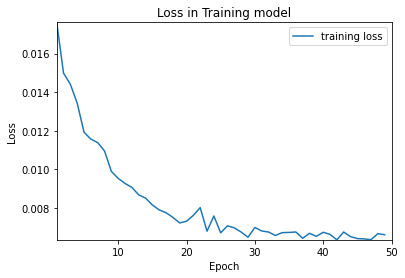

In [ ]:
plt.plot(hist_NYA.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, epochs)
plt.ylim(train_loss.min(),train_loss[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()

Appending the past 60 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 60 days, that is because we have set the model with 60 days timestep. 

In [ ]:
past_60_days = NYA_train.tail(60)
appended_NYA_test = past_60_days.append(NYA_test)

Scaling the test data before doing the predictions. 

In [ ]:
scaled_test_NYA = sc.fit_transform(appended_NYA_test)


Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 60 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 61st day in the test dataset. 

In [ ]:
X_test_NYA = []
y_test_NYA = []

for i in range(window,len(scaled_test_NYA)):
    X_test_NYA.append(scaled_test_NYA[(i-window):i,0])
    y_test_NYA.append(scaled_test_NYA[i,0])

X_test_NYA, y_test_NYA = np.array(X_test_NYA), np.array(y_test_NYA)

print(X_test_NYA.shape)
print(y_test_NYA.shape)



(1187, 60)
(1187,)


Data reshaping for prediction and plotting

In [ ]:
#reshaping the data for prediction
X_test_NYA = np.reshape(X_test_NYA,(X_test_NYA.shape[0], X_test_NYA.shape[1],1))
y_test_NYA= y_test_NYA.reshape(-1,1)

Predicting the price for the test 'labels' i.e. y-test values. 

In [ ]:
#Predictions
y_train_prediction = model.predict(X_train_NYA)
y_predict_NYA = model.predict(X_test_NYA)


38/38 [==============================] - 1s 28ms/step


Transforming the predicted values back to the unscaled form. 

In [ ]:
#reshaping the train data for transformation
y_train_NYA = y_train_NYA.reshape(-1,1)

#transform training data back to original form
predicted_train_NYA= sc.inverse_transform(y_train_prediction)
train_NYA= sc.inverse_transform(y_train_NYA)

#transform testing data back to original form
predicted_NYA= sc.inverse_transform(y_predict_NYA)
test_NYA= sc.inverse_transform(y_test_NYA)


Calculating the percentage difference between predicted and the actual price.

In [ ]:
NYA_test["Predicted"] = predicted_NYA

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

NYA_test["Percentage_diff"] =  percentage_change(NYA_test["Predicted"],NYA_test["Close"]) 
NYA_test

,Close,Predicted,Percentage_diff
Date,,,
2016-09-12,10741.24023,10859.322266,1.087379
2016-09-13,10535.36035,10845.543945,2.860010
2016-09-14,10511.40039,10782.441406,2.513726
2016-09-15,10602.94043,10735.829102,1.237805
2016-09-16,10532.26953,10746.703125,1.995343
...,...,...,...
2021-05-24,16464.68945,16056.866211,2.539868
2021-05-25,16390.18945,16185.830078,1.262582
2021-05-26,16451.96094,16023.495117,2.673985


Plotting the actual price vs the predicted price

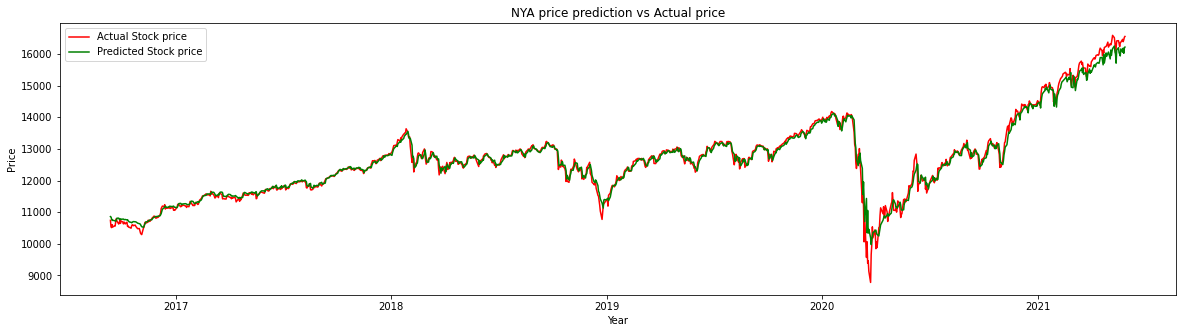

In [ ]:
plt.figure(figsize= (20,5))
plt.plot(NYA_test.index, NYA_test['Close'], color = 'red', label = 'Actual Stock price')
plt.plot(NYA_test['Predicted'], color = 'green', label = 'Predicted Stock price')
plt.title('NYA price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

Plotting the percentage difference between the prices. 

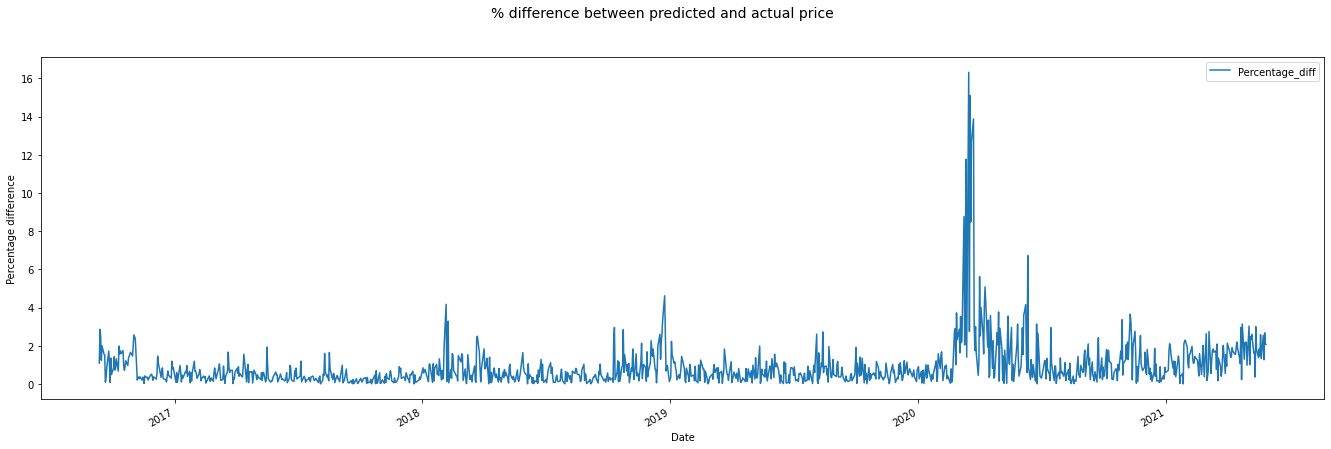

In [ ]:
NYA_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize=14, color='black')
plt.ylabel("Percentage difference")
plt.show()

---

In the above graph it is evident that the maximum price diference between the Actual Closing Price and the Predicted price happened when the pandemic hit the North America and the lockdowns were declared. The stock market was hit and prices fell suddenly.

---



Evaluating the model

In [ ]:
#Finding the Root Mean Squared error and Mean absolute error on the predictions

#Training data
print("Evaluations of the training data:")
print("RMSE of the training prediction:", round(math.sqrt(mean_squared_error(train_NYA, predicted_train_NYA)),2))
print("MAE of the training prediction:", round(mean_absolute_error(train_NYA, predicted_train_NYA),2))
print()
#Testing data
print("Evaluations of the testing data:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(test_NYA, predicted_NYA)), 2))
print("MAE of the testing prediction:", round(mean_absolute_error(test_NYA, predicted_NYA),2))

Evaluations of the training data:
RMSE of the training prediction: 66.27
MAE of the training prediction: 54.77

Evaluations of the testing data:
RMSE of the testing prediction: 179.82
MAE of the testing prediction: 108.29


For Analysis only: What if the Pandemic didn't hit and the market didn't crash?
For doing so I am disregarding the 4 months of data (prediction) for the RMSE and MAE calculation to see if the evaluation scores improve.

Removing the 4 months of data from the evaluation calculation where the market was the most hit due to the pandemic and the prices fell drastically the PMSE and MAE scores improved a little bit.

In [ ]:
NYA_test_pan = NYA_test.drop( NYA_test[ (NYA_test.index >= '2020-02-01') & (NYA_test.index <= '2020-06-01')].index )
print("RMSE of the pandemic testing prediction:", round(math.sqrt(mean_squared_error(NYA_test_pan["Close"], NYA_test_pan["Predicted"])), 2))
print("MAE of the testing prediction:", round(mean_absolute_error(NYA_test_pan["Close"], NYA_test_pan["Predicted"]),2))

RMSE of the pandemic testing prediction: 132.98
MAE of the testing prediction: 93.61


### LSTM for NASDAQ exchange

Predicting the IXIC(NASDAQ) stock exchange in the following cells. Steps taken are as follows

* Splitting the dataset into training and testing data sets
* Scaling the data using Standard Scaler
* Training dataset and testing dataset will both be divided into features and labels subset
* Creating the LSTM model
* Fitting data to the model
* Ploting the training loss and actual vs. predicted prices
* Calculating the mean squared error for both the training and test predictions.

In [ ]:
train_length_IXIC = math.ceil(len(IXIC) * .85) 

# taking 85% of data for training
IXIC_train = IXIC.iloc[:train_length_IXIC]

# taking 15% of data for testing (future data for prediction)
IXIC_test = IXIC.iloc[train_length_IXIC:]

print(IXIC_train.shape)
print(IXIC_test.shape)

(6727, 1)
(1187, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [ ]:
scaled_train_IXIC = sc.fit_transform(IXIC_train)
scaled_train_IXIC.shape

(6727, 1)

Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

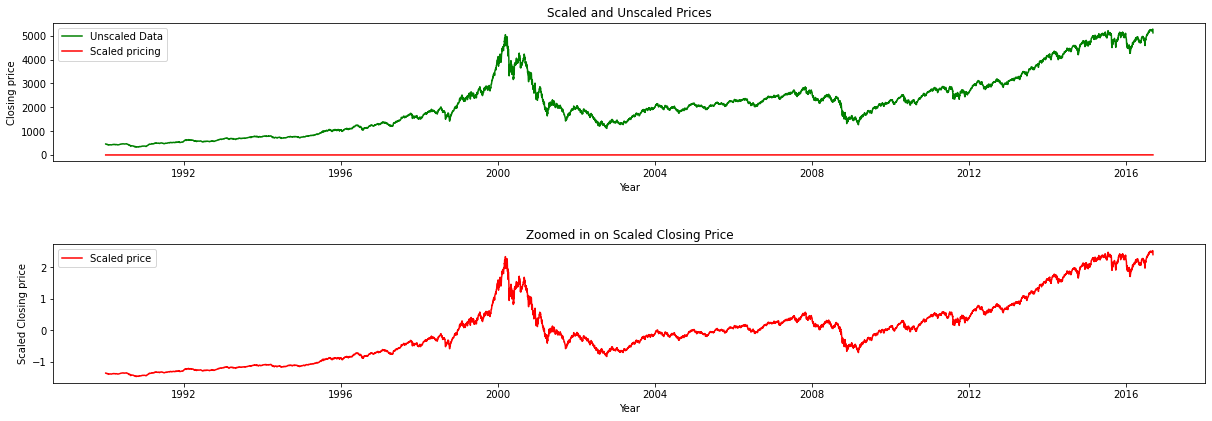

In [ ]:
scaled_IXIC_df = pd.DataFrame(scaled_train_IXIC, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
plt.plot(IXIC_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(IXIC_train.index, scaled_IXIC_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(IXIC_train.index,scaled_IXIC_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Dividing the data in such way is called a Sliding Window split, where the labels will be the data of Day 61 till the end of the dataset and will depend on the data from the previous 60 days. 

The window will slide till the end of the dataset, where features will always be 60 days sliding over by 1 day and the 61st data will be the label. 


In [ ]:
window = 60
X_train_IXIC = []
y_train_IXIC = []

for i in range(window,len(scaled_train_IXIC)): 
    X_train_IXIC.append(scaled_train_IXIC[(i-window):i,0])
    y_train_IXIC.append(scaled_train_IXIC[i,0])

X_train_IXIC, y_train_IXIC = np.array(X_train_IXIC),np.array(y_train_IXIC)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [ ]:
X_train_IXIC = np.reshape(X_train_IXIC, (X_train_IXIC.shape[0],X_train_IXIC.shape[1],1))
X_train_IXIC.shape

(6667, 60, 1)

<font size = 3>Creating the LSTM model </font>

In [ ]:
model = Sequential()

model.add(LSTM(units=50,activation = 'LeakyReLU', return_sequences= True, 
               input_shape = (X_train_IXIC.shape[1],1)))

model.add(LSTM(units= 50,activation = 'LeakyReLU', return_sequences=True))

model.add(LSTM(units= 50,activation = 'LeakyReLU', return_sequences=True))

model.add(LSTM(units= 50, activation = 'LeakyReLU', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units= 1))
model.compile(optimizer='adam',loss='mean_squared_error')


Fitting the model with training data

In [ ]:
epochs = 50
hist_IXIC = model.fit(X_train_IXIC,
                 y_train_IXIC,
                 epochs= epochs, 
                 batch_size=32, 
                 verbose= 1)  

Epoch 1/50
209/209 [==============================] - 31s 128ms/step - loss: 0.2132
Epoch 2/50
209/209 [==============================] - 24s 115ms/step - loss: 0.0284
Epoch 3/50
209/209 [==============================] - 23s 108ms/step - loss: 0.0245
Epoch 4/50
209/209 [==============================] - 22s 106ms/step - loss: 0.0230
Epoch 5/50
209/209 [==============================] - 23s 112ms/step - loss: 0.0200
Epoch 6/50
209/209 [==============================] - 24s 113ms/step - loss: 0.0195
Epoch 7/50
209/209 [==============================] - 23s 109ms/step - loss: 0.0175
Epoch 8/50
209/209 [==============================] - 24s 114ms/step - loss: 0.0160
Epoch 9/50
209/209 [==============================] - 23s 108ms/step - loss: 0.0147
Epoch 10/50
209/209 [==============================] - 23s 109ms/step - loss: 0.0149
Epoch 11/50
209/209 [==============================] - 23s 108ms/step - loss: 0.0144
Epoch 12/50
209/209 [==============================] - 23s 108ms/step - lo

Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [ ]:
train_loss2 = np.array(hist_IXIC.history['loss'])

Ploting the loss for each epoch





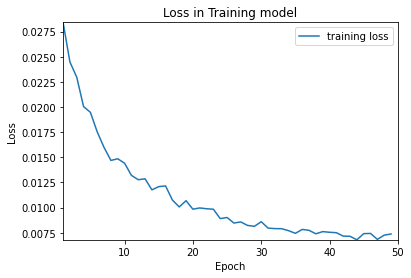

In [ ]:
plt.plot(hist_IXIC.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1,epochs)
plt.ylim(train_loss2.min(),train_loss2[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()


Appending the past 60 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 60 days, that is because we have set the model with 60 days timestep 

In [ ]:
past_60_days = IXIC_train.tail(60)
appended_IXIC_test = past_60_days.append(IXIC_test)

Scaling the test data before doing the predictions. 

In [ ]:
scaled_testDataIXIC = sc.fit_transform(appended_IXIC_test)

scaled_testDataIXIC.shape


(1247, 1)

Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 60 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 61st day in the test dataset. 

In [ ]:
X_test_IXIC = []
y_test_IXIC = []

for i in range(window,len(scaled_testDataIXIC)):
    X_test_IXIC.append(scaled_testDataIXIC[(i-window):i,0])
    y_test_IXIC.append(scaled_testDataIXIC[i,0])

X_test_IXIC, y_test_IXIC = np.array(X_test_IXIC), np.array(y_test_IXIC)

Data reshaping for prediction and plotting

In [ ]:
#reshaping the data for prediction
X_test_IXIC = np.reshape(X_test_IXIC,(X_test_IXIC.shape[0], X_test_IXIC.shape[1],1))
y_test_IXIC = y_test_IXIC.reshape(-1,1)

print(X_test_IXIC.shape)
print(y_test_IXIC.shape)

(1187, 60, 1)
(1187, 1)


Predicting the price for the test 'labels' i.e. y-test values. 

In [ ]:
#Predictions
y_train_predict_IXIC = model.predict(X_train_IXIC)
y_test_predict_IXIC = model.predict(X_test_IXIC)


38/38 [==============================] - 1s 35ms/step


Transforming the predicted values back to the unscaled form. 

In [ ]:
#reshaping the train data
y_train_IXIC = y_train_IXIC.reshape(-1,1)

#transforming train set back to original form
predicted_train_IXIC = sc.inverse_transform(y_train_predict_IXIC)
train_IXIC = sc.inverse_transform(y_train_IXIC)

#transforming test set back to original form
predicted_IXIC= sc.inverse_transform(y_test_predict_IXIC)
test_IXIC= sc.inverse_transform(y_test_IXIC)


Creating a new column with the predicted values along with the actual closing price of the Test dataset and calculating the percentage difference between the prices. 

In [ ]:
IXIC_test["Predicted"] = predicted_IXIC

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

IXIC_test["Percentage_diff"] =  percentage_change(IXIC_test["Predicted"],IXIC_test["Close"]) 
IXIC_test

,Close,Predicted,Percentage_diff
Date,,,
2016-09-12,5211.890137,5260.172852,0.917892
2016-09-13,5155.250000,5253.065918,1.862073
2016-09-14,5173.770020,5246.164551,1.379952
2016-09-15,5249.689941,5242.621582,0.134825
2016-09-16,5244.569824,5268.014160,0.445032
...,...,...,...
2021-05-24,13661.169920,13232.643555,3.238403
2021-05-25,13657.169920,13411.475586,1.831971
2021-05-26,13738.000000,13391.705078,2.585891


Plotting the actual price vs the predicted price

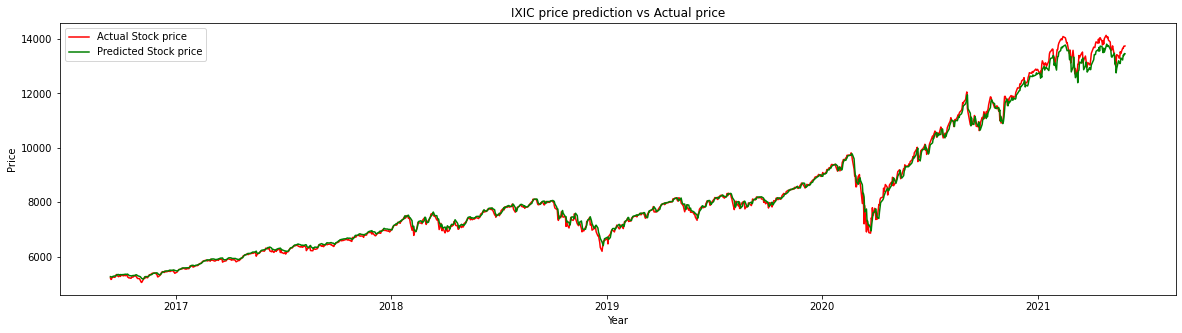

In [ ]:
plt.figure(figsize= (20,5))
plt.plot(IXIC_test.index,IXIC_test["Close"], color = 'red', label = 'Actual Stock price')
plt.plot(IXIC_test["Predicted"], color = 'green', label = 'Predicted Stock price')
plt.title('IXIC price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

Plotting the percentage difference between the prices. 

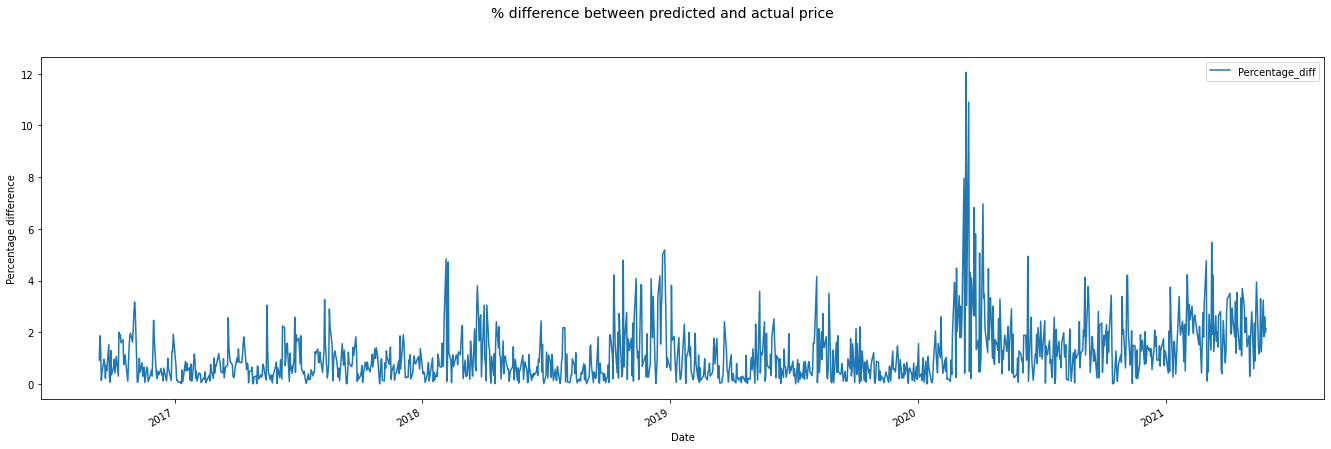

In [ ]:
IXIC_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize=14, color='black')
plt.ylabel("Percentage difference")
plt.show()

---

In the above graph it is evident that the maximum price diference between the Actual Closing Price and the Predicted price happened when the pandemic hit the North America and the lockdowns were declared. The stock market was hit and prices fell suddenly.

---



Evaluating the model

In [ ]:
#Finding the Root Mean Squared error on the training data
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Finding the Mean Squared error on the scaled testing data
print("Evaluating the training predictions:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(train_IXIC, predicted_train_IXIC)),2))
print("MAE of the testing prediction:", round(mean_absolute_error(train_IXIC, predicted_train_IXIC),2))
print()
#Finding the Mean Squared error on the unscaled testing data
print("Evaluating the testing predictions:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(test_IXIC, predicted_IXIC)),2))
print("MAE of the testing prediction:", round(mean_absolute_error(test_IXIC, predicted_IXIC),2))

Evaluating the training predictions:
RMSE of the testing prediction: 100.92
MAE of the testing prediction: 71.48

Evaluating the testing predictions:
RMSE of the testing prediction: 146.89
MAE of the testing prediction: 97.51


For Analysis only: What if the Pandemic didn't hit and the market didn't crash?
For doing so I am disregarding the 4 months of data (prediction) for the RMSE and MAE calculation to see if the evaluation scores improve.

Removing the 4 months of data from the evaluation calculation where the market was the most hit due to the pandemic and the prices fell drastically the RMSE and MAE scores improved a little bit.

In [ ]:
IXIC_test_pan = IXIC_test.drop( IXIC_test[ (IXIC_test.index >= '2020-02-01') & (IXIC_test.index <= '2020-06-01')].index )
#Finding the Mean Squared error on the unscaled testing data, pandemic start 3 months removed
print("Evaluating the testing predictions, pandemic start 4 months removed:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(IXIC_test_pan['Close'], IXIC_test_pan['Predicted'])),2))
print("MAE of the testing prediction:", round(mean_absolute_error(IXIC_test_pan['Close'], IXIC_test_pan['Predicted']),2))

Evaluating the testing predictions, pandemic start 4 months removed:
RMSE of the testing prediction: 135.54
MAE of the testing prediction: 91.04


### LSTM for Toronto Stock Exchange

Predicting the GSPTSE(Toronto Exchange) stock exchange in the following cells. Steps taken are as follows

* Splitting the dataset into training and testing data sets
* Scaling the data using Standard Scaler
* Training dataset and testing dataset will both be divided into features and labels subset
* Creating the LSTM model
* Fitting data to the model
* Ploting the training loss and actual vs. predicted prices
* Calculating the mean squared error for both the training and test predictions.

In [ ]:
train_length_GSPTSE = math.ceil(len(GSPTSE) * .85) 

#taking 85% of the data for training
GSPTSE_train = GSPTSE.iloc[:train_length_GSPTSE]

# taking 15% of data for testing
GSPTSE_test = GSPTSE.iloc[train_length_GSPTSE:]

print(GSPTSE_train.shape)
print(GSPTSE_test.shape)

(6830, 1)
(1205, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [ ]:
scaled_train_GSPTSE = sc.fit_transform(GSPTSE_train)
print(scaled_train_GSPTSE.shape)

(6830, 1)


Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

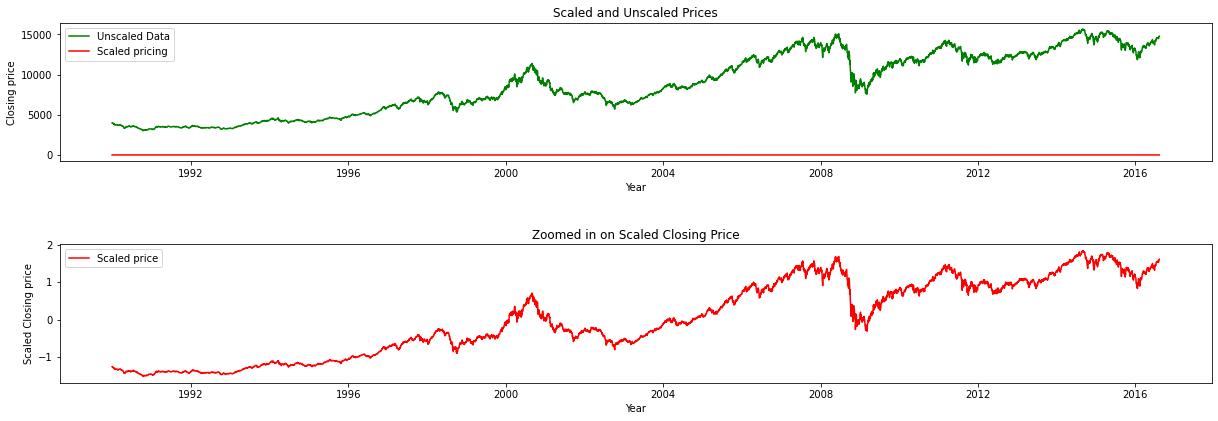

In [ ]:
scaled_GSPTSE_df = pd.DataFrame(scaled_train_GSPTSE, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
plt.plot(GSPTSE_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(GSPTSE_train.index, scaled_GSPTSE_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(GSPTSE_train.index,scaled_GSPTSE_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Dividing the data in such way is called a Sliding Window split, where the labels will be the data of Day 61 till the end of the dataset and will depend on the data from the previous 60 days. 

The window will slide till the end of the dataset, where features will always be 60 days sliding over by 1 day and the 61st data will be the label. 


In [ ]:
window = 60
X_train_GSPTSE= []
y_train_GSPTSE = []

for i in range(window,len(scaled_train_GSPTSE)): 
    X_train_GSPTSE.append(scaled_train_GSPTSE[(i-window):i,0])
    y_train_GSPTSE.append(scaled_train_GSPTSE[i,0])

X_train_GSPTSE, y_train_GSPTSE = np.array(X_train_GSPTSE),np.array(y_train_GSPTSE)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [ ]:
X_train_GSPTSE = np.reshape(X_train_GSPTSE, (X_train_GSPTSE.shape[0],X_train_GSPTSE.shape[1],1))
print(X_train_GSPTSE.shape)

(6770, 60, 1)


<font size = 3>Creating the LSTM model </font>

In [ ]:
model3 = Sequential()

model3.add(LSTM(units=50,activation = 'LeakyReLU', return_sequences= True, 
               input_shape = (X_train_GSPTSE.shape[1],1)))

model3.add(LSTM(units=50,activation = 'LeakyReLU', return_sequences=True))

model3.add(LSTM(units= 50, activation = 'LeakyReLU', return_sequences= True))

model3.add(LSTM(units= 50, activation = 'LeakyReLU', return_sequences=False))
model3.add(Dropout(0.2))

model3.add(Dense(units= 1))
model3.compile(optimizer='adam',loss='mean_squared_error')


In [ ]:
#Checking the summary of the model created
model3.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_20 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_21 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_22 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Fitting the model with training data

In [ ]:
epochs = 50
hist_GSPTSE = model3.fit(X_train_GSPTSE,
                        y_train_GSPTSE,
                        epochs= epochs, 
                        batch_size=32, 
                        verbose= 1)  #using verbose=2 to see the loss in each step.

Epoch 1/50
212/212 [==============================] - 35s 137ms/step - loss: 0.1199
Epoch 2/50
212/212 [==============================] - 29s 137ms/step - loss: 0.0221
Epoch 3/50
212/212 [==============================] - 29s 139ms/step - loss: 0.0191
Epoch 4/50
212/212 [==============================] - 29s 135ms/step - loss: 0.0167
Epoch 5/50
212/212 [==============================] - 29s 139ms/step - loss: 0.0151
Epoch 6/50
212/212 [==============================] - 29s 136ms/step - loss: 0.0152
Epoch 7/50
212/212 [==============================] - 30s 143ms/step - loss: 0.0141
Epoch 8/50
212/212 [==============================] - 29s 138ms/step - loss: 0.0130
Epoch 9/50
212/212 [==============================] - 29s 136ms/step - loss: 0.0128
Epoch 10/50
212/212 [==============================] - 29s 137ms/step - loss: 0.0118
Epoch 11/50
212/212 [==============================] - 29s 137ms/step - loss: 0.0112
Epoch 12/50
212/212 [==============================] - 29s 136ms/step - lo

Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [ ]:
train_loss3 = np.array(hist_GSPTSE.history['loss'])

Ploting the loss for each epoch





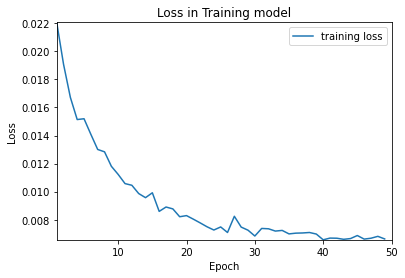

In [ ]:
plt.plot(hist_GSPTSE.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1,epochs)
plt.ylim(train_loss3.min(),train_loss3[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()


Appending the past 60 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 60 days, that is because we have set the model with 60 days timestep 

In [ ]:
past_60_days_GSPTSE = GSPTSE_train.tail(60)
appended_GSPTSE_test = past_60_days_GSPTSE.append(GSPTSE_test)

Scaling the test data before doing the predictions. 

In [ ]:
scaled_test_GSPTSE = sc.fit_transform(appended_GSPTSE_test)

Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 60 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 61st day in the test dataset. 

In [ ]:
X_test_GSPTSE = []
y_test_GSPTSE = []

for i in range(window,len(scaled_test_GSPTSE)):
    X_test_GSPTSE.append(scaled_test_GSPTSE[(i-window):i,0])
    y_test_GSPTSE.append(scaled_test_GSPTSE[i,0])

X_test_GSPTSE, y_test_GSPTSE = np.array(X_test_GSPTSE), np.array(y_test_GSPTSE)

Data reshaping for prediction and plotting

In [ ]:
#reshaping the data for prediction
X_test_GSPTSE = np.reshape(X_test_GSPTSE,(X_test_GSPTSE.shape[0], X_test_GSPTSE.shape[1],1))
y_test_GSPTSE = y_test_GSPTSE.reshape(-1,1)

print(X_test_GSPTSE.shape)
print(y_test_GSPTSE.shape)

(1205, 60, 1)
(1205, 1)


Predicting the price for the test 'labels' i.e. y-test values. 

In [ ]:
#Predictions
y_train_predict_GSPTSE = model3.predict(X_train_GSPTSE)
y_test_predict_GSPTSE = model3.predict(X_test_GSPTSE)

38/38 [==============================] - 1s 34ms/step


Transforming the predicted values back to the unscaled form. 

In [ ]:
#reshaping the train data
y_train_GSPTSE = y_train_GSPTSE.reshape(-1,1)

#transforming train set back to original form
predicted_train_GSPTSE = sc.inverse_transform(y_train_predict_GSPTSE)
train_GSPTSE = sc.inverse_transform(y_train_GSPTSE)

#transforming test set back to original form
predicted_GSPTSE= sc.inverse_transform(y_test_predict_GSPTSE)
test_GSPTSE= sc.inverse_transform(y_test_GSPTSE)


Creating a new column with the predicted values along with the actual closing price of the Test dataset and calculating the percentage difference between the prices. 

In [ ]:
GSPTSE_test["Predicted"] = predicted_GSPTSE

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

GSPTSE_test["Percentage_diff"] =  percentage_change(GSPTSE_test["Predicted"],GSPTSE_test["Close"]) 
GSPTSE_test

,Close,Predicted,Percentage_diff
Date,,,
2016-08-11,14796.09961,14782.790039,0.090034
2016-08-12,14747.50000,14778.306641,0.208459
2016-08-15,14777.00000,14755.140625,0.148148
2016-08-16,14703.40039,14749.475586,0.312385
2016-08-17,14697.59961,14730.328125,0.222185
...,...,...,...
2021-05-25,19564.09961,19268.765625,1.532708
2021-05-26,19745.50000,19272.068359,2.456569
2021-05-27,19774.40039,19475.722656,1.533590


Plotting the actual price vs the predicted price

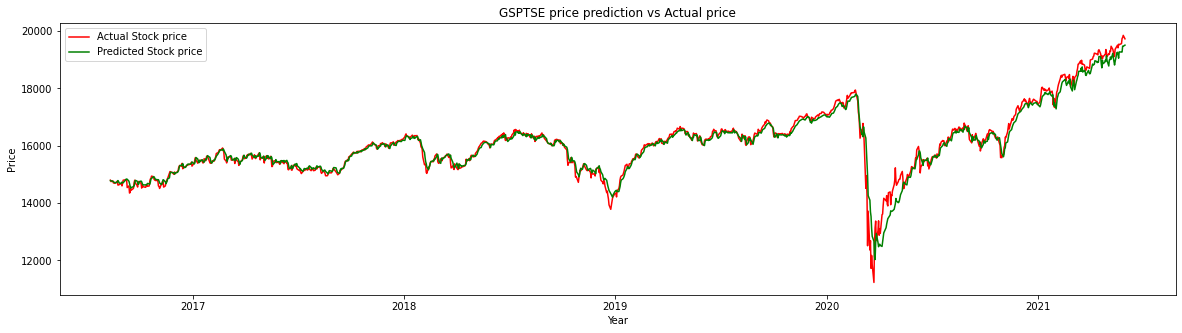

In [ ]:
plt.figure(figsize= (20,5))
plt.plot(GSPTSE_test.index,GSPTSE_test["Close"], color = 'red', label = 'Actual Stock price')
plt.plot(GSPTSE_test["Predicted"], color = 'green', label = 'Predicted Stock price')
plt.title('GSPTSE price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

Plotting the percentage difference between the actual and predicted value.

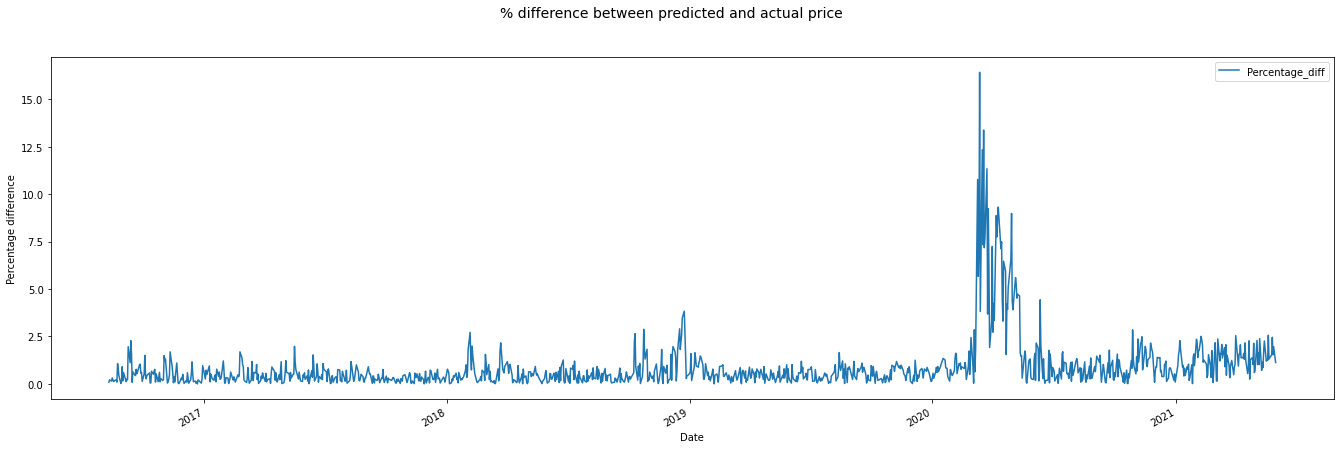

In [ ]:
GSPTSE_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize = 14)
plt.ylabel("Percentage difference")
plt.show()

Evaluating the model

In [ ]:
#Finding the Root Mean Squared error and Mean absolute error on the predictions

#Training data
print("Evaluating the training predictions:")
print("RMSE of the training prediction:", round(math.sqrt(mean_squared_error(train_GSPTSE, predicted_train_GSPTSE)),2))
print("MAE of the training prediction:", round(mean_absolute_error(train_GSPTSE, predicted_train_GSPTSE),2))
print()
#Testing data
print("Evaluating the testing predictions:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(test_GSPTSE, predicted_GSPTSE)),2))
print("MAE of the testing prediction:", round(mean_absolute_error(test_GSPTSE, predicted_GSPTSE),2))

Evaluating the training predictions:
RMSE of the training prediction: 71.74
MAE of the training prediction: 58.72

Evaluating the testing predictions:
RMSE of the testing prediction: 235.1
MAE of the testing prediction: 133.48


For Analysis only: What if the Pandemic didn't hit and the market didn't crash?
For doing so I am disregarding the 4 months of data (prediction) for the RMSE and MAE calculation to see if the evaluation scores improve.

Removing the 4 months of data from the evaluation calculation where the market was the most hit due to the pandemic and the prices fell drastically the PMSE and MAE scores improved a little bit.

In [ ]:
GSPTSE_test_pan = GSPTSE_test.drop( GSPTSE_test[ (GSPTSE_test.index >= '2020-02-01') & (GSPTSE_test.index <= '2020-06-01')].index )
#Finding the Mean Squared error on the unscaled testing data, pandemic start 3 months removed
print("Removing the pandemic prediction of starting 4 months:")
print("RMSE of the testing prediction:", round(math.sqrt(mean_squared_error(GSPTSE_test_pan['Close'], GSPTSE_test_pan['Predicted'])),2))
print("MAE of the testing prediction:", round(mean_absolute_error(GSPTSE_test_pan['Close'], GSPTSE_test_pan['Predicted']),2))

Removing the pandemic prediction of starting 4 months:
RMSE of the testing prediction: 140.79
MAE of the testing prediction: 104.06


## Conclusion
   This project in no means is ready for the real world market predictions. Stock markets are dependent on various other external factors, including, geo-political news, seasonality, company news, etc., to name just a few. Like we saw in our predictions that when the Pandemic hit the Northern America the prices of the markets fell drastically and this resulted in poor predictions. For better stock market predictions other data should also be considered that could be fit to the models created for better accuracy. 

   This project was created for academic purpose only. 